In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from ruptures import Dynp, Pelt
from src.cpop import CPOP
from scipy.stats import median_abs_deviation
from src.utils import linear_segment_cost

In [480]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [481]:
data_df = pd.read_csv('./data/TN stock market/ALL_DATA.csv')

## Pre-processing

In [482]:
data_df.head()

,Ticker,Date,Open,High,Low,Close,Volume
0,AB,2022-10-24,24.58,24.58,24.58,24.58,130
1,AB,2022-10-26,23.90,24.58,23.90,23.90,14301
2,AB,2022-10-27,24.58,24.58,24.57,24.58,505
3,AB,2022-10-28,24.58,24.58,24.09,24.58,5882
4,AB,2022-10-31,24.58,24.58,24.57,24.58,1240


We will focus on the "High" column

In [483]:
data_df = data_df[["Ticker", "Date", "Close"]]

In [484]:
stocks = data_df['Ticker'].unique()
print("The number of stocks is: ", len(stocks))

The number of stocks is:  88


## Number of missing points

Very minimal ==> we remove the missing points from the dataframe

In [485]:
data_df_null = data_df[data_df.isnull().any(axis=1)]
# count by Ticker
null_by_stock = {}
for stock in stocks:
    if len(data_df_null[data_df_null['Ticker'] == stock]) != 0:
        null_by_stock[stock] = len(data_df_null[data_df_null['Ticker'] == stock])

print("The number of stocks with missing values is: ", len(null_by_stock))
for stock in null_by_stock:
    print("Stock: ", stock, " has ", null_by_stock[stock], " missing values (", round(null_by_stock[stock]/len(data_df[data_df['Ticker'] == stock])*100, 2), "%)")

The number of stocks with missing values is:  3
Stock:  AST  has  10  missing values ( 1.51 %)
Stock:  PLTU  has  10  missing values ( 3.19 %)
Stock:  SIMPA  has  2  missing values ( 0.1 %)


In [486]:
data_df = data_df.dropna()

In [487]:
(data_df.duplicated().sum() / len(data_df))*100
# see where the duplicates are
df_duplicates = pd.DataFrame(data_df[data_df.duplicated(keep=False)].sort_values(by=['Ticker', 'Date']).groupby(['Ticker']).count())
data_df[data_df.duplicated(keep=False)].sort_values(by=['Ticker', 'Date']).groupby(['Ticker']).count()
# supress column Dates of df_duplicates
df_duplicates = df_duplicates.drop(columns=['Date'])
# rename column Close to Number of duplicates
df_duplicates = df_duplicates.rename(columns={'Close': 'Number of duplicates'})
# add column with the total number of rows for each stock
df_duplicates['Total number of rows'] = data_df.groupby(['Ticker']).count()['Date']
# add column with the percentage of duplicates
df_duplicates['Percentage of duplicates'] = df_duplicates['Number of duplicates'] / df_duplicates['Total number of rows'] * 100
# sort by Percentage of duplicates
df_duplicates = df_duplicates.sort_values(by=['Percentage of duplicates'], ascending=False)
# round percentage of duplicates to 2 decimals
df_duplicates['Percentage of duplicates'] = df_duplicates['Percentage of duplicates'].round(decimals=2)

C:\Users\ezzeh\AppData\Local\Temp\ipykernel_25440\1121688345.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_duplicates.index, rotation=90, fontsize=12)


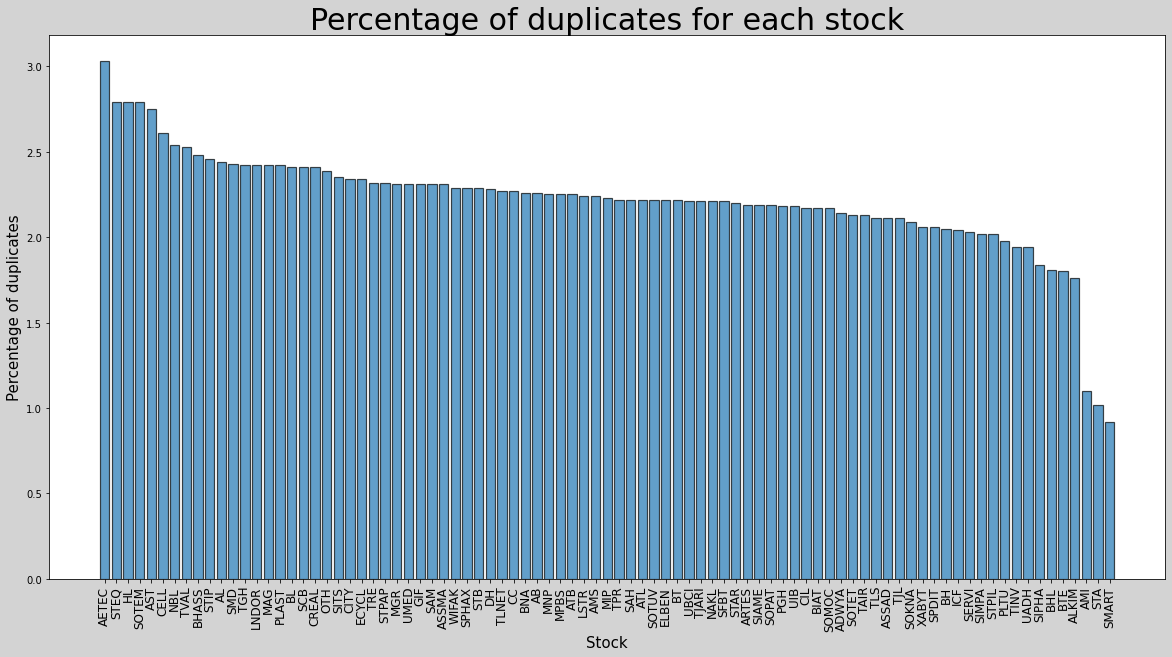

In [488]:
# plot the percentage of duplicates
fig, ax = plt.subplots(figsize=(20,10))
fig.patch.set_facecolor('lightgrey')
ax.patch.set_facecolor('white')
ax.bar(df_duplicates.index, df_duplicates['Percentage of duplicates'], edgecolor='black', linewidth=1.2, alpha=0.7)
ax.set_xticklabels(df_duplicates.index, rotation=90, fontsize=12)
ax.set_xlabel('Stock', fontsize=15)
ax.set_ylabel('Percentage of duplicates', fontsize=15)
ax.set_title('Percentage of duplicates for each stock', fontsize=30)
plt.show()

### We remove duplicates

In [489]:
# remove duplicates
data_df = data_df.drop_duplicates()

### We convert the dates to ints

In [490]:
# We convert the dataframe to a dictionary of tuples. The keys are the stock names and the values are a tuple of the dates and the closing prices.

stock_dict = {}
for stock in stocks:
    stock_dict[stock] = (data_df[data_df['Ticker'] == stock]['Date'], data_df[data_df['Ticker'] == stock]['Close'])

In [491]:
for stock in stocks:
    X, y = stock_dict[stock][0].values, stock_dict[stock][1].values
    X_int = []
    for date in X:
        year, month, date = date.split('-')
        date = datetime.date(int(year), int(month), int(date))
        X_int.append(date.toordinal())
    # indices sort
    X_int = np.array(X_int)
    indices = np.argsort(X_int)
    X_int = X_int[indices]
    y = y[indices]
    X_int = X_int - X_int[0]
    stock_dict[stock] = (X_int, y)

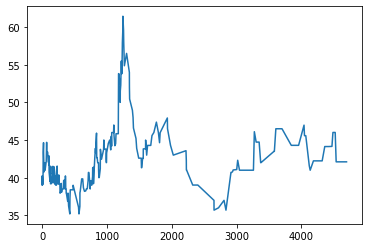

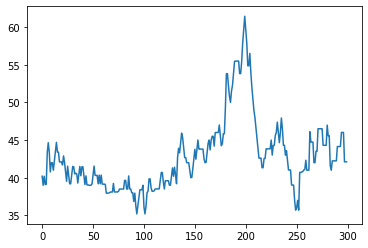

In [492]:
X_exple, y_exple = stock_dict['PLTU']
plt.plot(X_exple, y_exple)
plt.show()
plt.plot(y_exple)
plt.show()

In [493]:
def interpolate_linearly(X, y):
    X_int, y_int = [], []
    for i in range(len(X)-1):
        slope = (y[i+1] - y[i])/(X[i+1] - X[i])
        for j in range(X[i], X[i+1]):
            X_int.append(j)
            y_int.append(y[i] + slope*(j - X[i]))
    return np.array(X_int), np.array(y_int)


In [494]:
stock_dict_int = {}
for stock in stocks:
    X, y = stock_dict[stock][0], stock_dict[stock][1]
    X_int, y_int = interpolate_linearly(X, y)
    stock_dict_int[stock] = (X_int, y_int)

## Histogram of sizes by stock

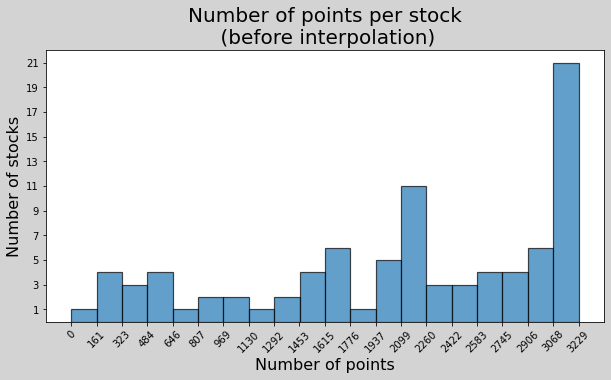

In [495]:
size_by_stock = {}
for stock in stocks:
    size_by_stock[stock] = len(stock_dict[stock][0])

sizes = list(size_by_stock.values())

fig, ax = plt.subplots(figsize=(10, 5))
fig.set_facecolor('lightgrey')
ax.set_facecolor('white')
ax.set_title('Number of points per stock\n (before interpolation)', fontsize=20)
# align ticks with bins
step = np.max(sizes)/20
ticks = [0]
for i in range(20):
    ticks.append(ticks[-1] + step)
ax.set_xticks(ticks)
ax.set_yticks([i for i in range(1, 25, 2)])
# set tick orientation
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_xlabel('Number of points', fontsize=16)
ax.set_ylabel('Number of stocks', fontsize=16)
ax.hist(sizes, bins=20, edgecolor='black', linewidth=1.2, alpha=0.7)
plt.show()

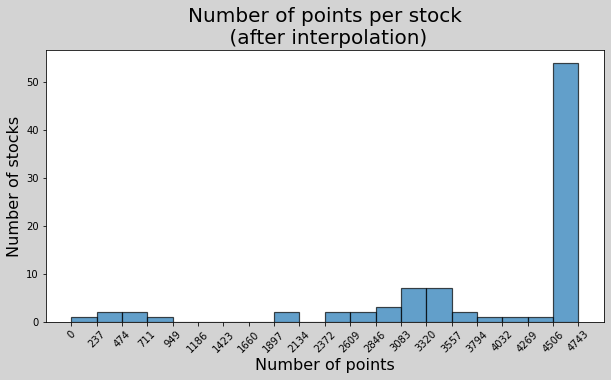

In [496]:
size_by_stock_int = {}
for stock in stocks:
    size_by_stock_int[stock] = len(stock_dict_int[stock][0])

sizes = list(size_by_stock_int.values())

fig, ax = plt.subplots(figsize=(10, 5))
fig.set_facecolor('lightgrey')
ax.set_facecolor('white')
ax.set_title('Number of points per stock\n (after interpolation)', fontsize=20)
# align ticks with bins
step = np.max(sizes)/20
ticks = [0]
for i in range(20):
    ticks.append(ticks[-1] + step)
ax.set_xticks(ticks)
# ax.set_yticks([i for i in range(1, 25, 2)])
# set tick orientation
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_xlabel('Number of points', fontsize=16)
ax.set_ylabel('Number of stocks', fontsize=16)
ax.hist(sizes, bins=20, edgecolor='black', linewidth=1.2, alpha=0.7)
plt.show()

### We sub-sample to get at most n_sub_sample points

In [497]:
stock_dict_subsample = {}
n_sub_sample = 500
for stock in stocks:
    X, y = stock_dict_int[stock][0], stock_dict_int[stock][1]
    if len(X) > n_sub_sample:
        # subsample the time series to n_sub_sample points at fixed intervals
        subsample_indices = np.linspace(0, len(X)-1, n_sub_sample, dtype=int)
        X = X[subsample_indices]
        y = y[subsample_indices]
    stock_dict_subsample[stock] = (X, y)

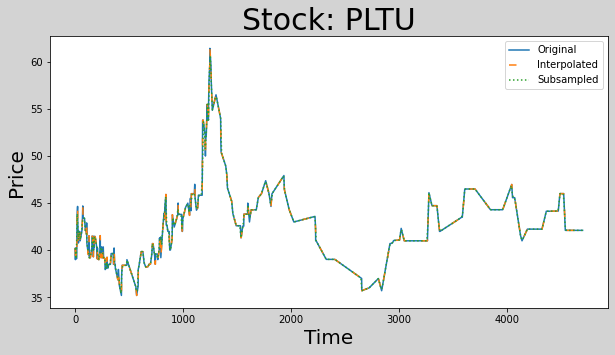

In [498]:
stock = 'PLTU'
X_emp, y_emp = stock_dict[stock][0], stock_dict[stock][1]
X_int, y_int = stock_dict_int[stock][0], stock_dict_int[stock][1]
X_sub, y_sub = stock_dict_subsample[stock][0], stock_dict_subsample[stock][1]

fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('lightgrey')
ax.patch.set_facecolor('white')
ax.set_title('Stock: ' + stock, fontsize=30)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Price', fontsize=20)

ax.plot(X_emp, y_emp, label='Original')
# wide dashes
ax.plot(X_int, y_int, label='Interpolated', linestyle = '--', dashes=(5, 10))
ax.plot(X_sub, y_sub, label='Subsampled', linestyle = ':')
ax.legend(fontsize=10)
plt.show()


### We visualize the stocks that have a size that is too small

Stock:  AMI  has  180  points


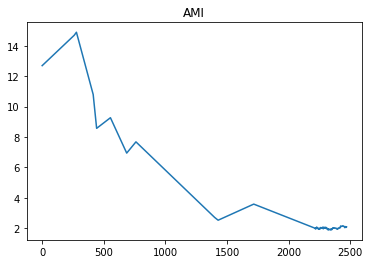

Stock:  AMV  has  1  points


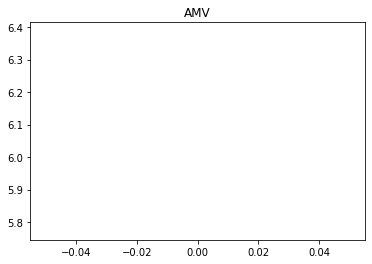

Stock:  STA  has  196  points


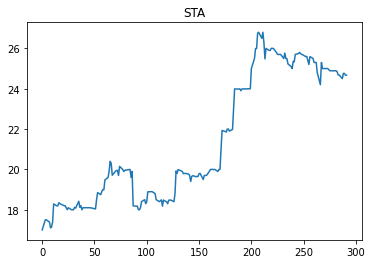

In [499]:
for stock in stocks:
    if size_by_stock[stock] < 200:
        print("Stock: ", stock, " has ", size_by_stock[stock], " points")
        plt.plot(stock_dict[stock][0], stock_dict[stock][1])
        plt.title(stock)
        plt.show()

### We remove them

In [500]:
for stock in stocks:
    if size_by_stock[stock] < 200:
        stock_dict.pop(stock)

stocks = list(stock_dict.keys())

## First tests of the CPOP algorithm

In [512]:
from src.plots import *
import os

Stock:  AB  ( 1 / 2 )
Iterations 450/500 : 727 taus stored


c:\Users\ezzeh\OneDrive\Bureau\Master MVA\Machine learning for Time series\CPOP\src\plots.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xlabel('Time', fontsize=15)


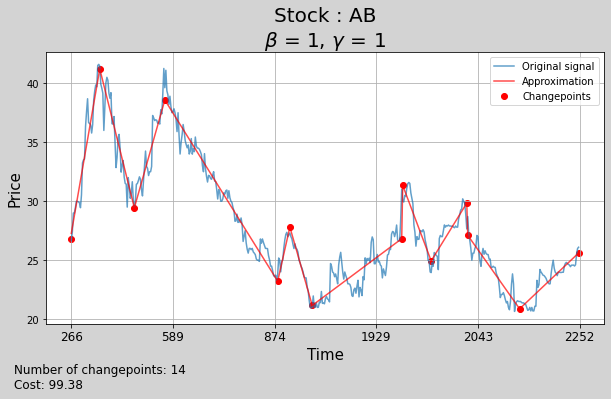

Stock:  ADWYA  ( 2 / 2 )
Iterations 450/500 : 738 taus storedd


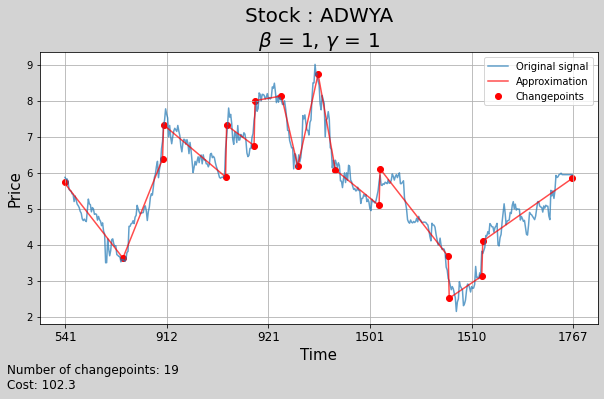

In [513]:
save = True

# Fix hyperparameters
beta = 1
scale = 1

for i, stock_name in enumerate(stocks[:2]):
    print("Stock: ", stock_name, " (", i+1, "/", len(stocks[:2]), ")")
    X, y = stock_dict_subsample[stock_name][0], stock_dict_subsample[stock_name][1]

    sigma=median_abs_deviation(y)
    changepoints_cpop = CPOP(y, beta, sigma = sigma, scale = scale, verbose=True)

    approx, fig = get_approx(y, changepoints_cpop, beta, sigma, scale = scale, stock_name=stock_name, X = X)
    if save :
        folder = './figures/all_stocks_beta_{}_scale_{}'.format(beta, scale) + '/'
        file = '{}'.format(stock_name) + '.png'
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        path = folder + file
        fig.savefig(path, bbox_inches='tight')

## Beta influence analysis

Iterations 450/500 : 29 taus stored


c:\Users\ezzeh\OneDrive\Bureau\Master MVA\Machine learning for Time series\CPOP\src\plots.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xlabel('Time', fontsize=15)


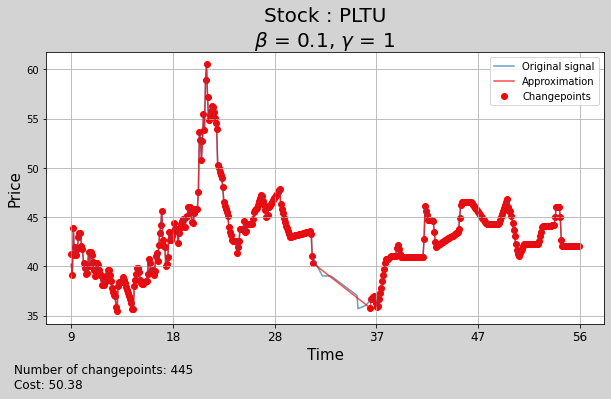

Iterations 450/500 : 462 taus stored


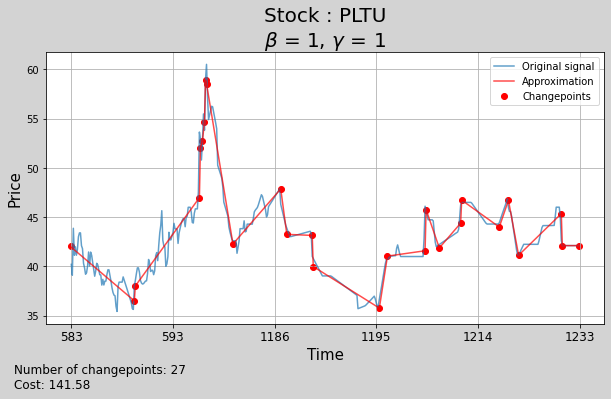

KeyboardInterrupt: 

In [515]:
save = True

stock = 'PLTU'
beta_list = [0.1, 1, 5, 10, 20]
sigma = median_abs_deviation(stock_dict_subsample[stock][1])
scale = 1

X, y = stock_dict_subsample[stock][0], stock_dict_subsample[stock][1]
for beta in beta_list:
    changepoints_cpop = CPOP(y, beta, sigma = sigma, scale = scale, verbose=True)
    approx, fig = get_approx(y, changepoints_cpop, beta, sigma, scale = scale, stock_name=stock, X = X)
    if save :
        folder = './figures/beta_analysis_scale_{}_stock_{}'.format(scale, stock) + '/'
        file = 'beta_{}'.format(beta) + '.png'
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        path = folder + file
        fig.savefig(path, bbox_inches='tight')

## $h$ scale influence analysis

Iterations 450/500 : 226 taus stored


c:\Users\ezzeh\OneDrive\Bureau\Master MVA\Machine learning for Time series\CPOP\src\plots.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xlabel('Time', fontsize=15)


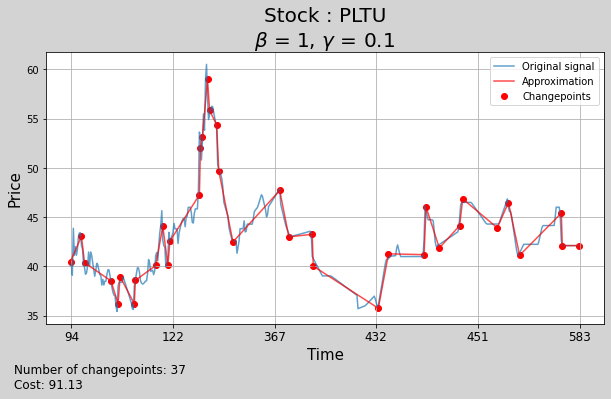

Manual cost:  156.15845089107586
Returned cost:  91.12713430917415
Iterations 450/500 : 462 taus stored


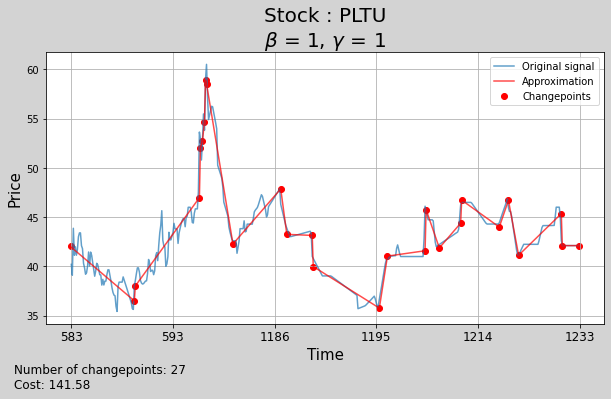

KeyboardInterrupt: 

In [516]:
save = True

stock = 'PLTU'
scale_list = [0.1, 1, 5, 10, 20]
sigma = median_abs_deviation(stock_dict_subsample[stock][1])
beta = 1

X, y = stock_dict_subsample[stock][0], stock_dict_subsample[stock][1]
for scale in scale_list:
    changepoints_cpop = CPOP(y, beta, sigma = sigma, scale = scale, verbose=True)
    approx, fig = get_approx(y, changepoints_cpop, beta, sigma, scale = scale, stock_name=stock, X = X)
    if save :
        folder = './figures/scale_analysis_beta_{}_stock_{}'.format(beta, stock) + '/'
        file = 'scale_{}'.format(scale) + '.png'
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        path = folder + file
        fig.savefig(path, bbox_inches='tight')